In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os, torch, pickle
from jarvis.utils import tqdm
from hexarena import DATA_DIR, STORE_DIR

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng()

# Policy identification using hidden Markov model

## Gather results of all trained HMMs

In [2]:
from hexarena.scripts.identify_policies import create_manager

subject, kappa, num_samples = 'marco', 0.01, 1000
z_dim, num_macros = 3, 10
manager = create_manager(subject, kappa, num_samples, z_dim=z_dim, num_macros=num_macros)

Collect data:   0%|                                                                                           …

In [3]:
from hexarena.scripts.identify_policies import e_step

knowns, beliefs, actions = manager.knowns, manager.beliefs, manager.actions
block_ids = manager.block_ids

keys, lls_full, metrics = [], {}, {}
for key, config in tqdm(list(manager.completed(min_epoch=40, cond={'z_dim': z_dim, 'kappa': kappa, 'num_samples': num_samples}))):
    keys.append(key)
    manager.setup(config)
    manager.load_ckpt(manager.ckpts[key])

    ll = manager.ckpts[key]['ll_test']
    log_pi = manager.hmp.log_pi.clone()
    for _ in range(20): # equilibrium distribution
        log_pi = torch.stack([torch.logsumexp(manager.hmp.log_A[:, i]+log_pi, dim=0) for i in range(manager.hmp.num_policies)])
    ent = -(log_pi.exp()*log_pi).sum().item()
    p_dwell = (manager.hmp.log_A.diag()+log_pi).exp().sum().item()
    if p_dwell>3:
        raise

    metrics[key] = (ll, ent, p_dwell)

  0%|                                                                                                         …

## Filter out only good solutions

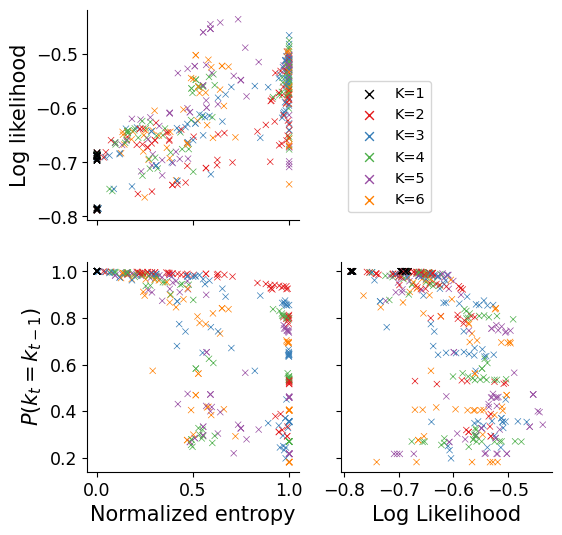

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
palette = np.stack([(0, 0, 0), *mpl.colormaps['Set1'].colors[:5]])
lls, ents, ps_dwell = [], [], []
colors = []

k_min, k_max = 1, 7
for num_policies in range(k_min, k_max):
    _lls, _ents, _ps_dwell = np.array([
        metrics[key] for key in keys if manager.configs[key].num_policies==num_policies
    ]).T
    if num_policies>1:
        _ents /= np.log(num_policies)
    lls.append(_lls); ents.append(_ents); ps_dwell.append(_ps_dwell)
    colors.append(np.tile(palette[num_policies-1][None], (len(_lls), 1)))
lls = np.concatenate(lls); ents = np.concatenate(ents); ps_dwell = np.concatenate(ps_dwell)
colors = np.concatenate(colors)
idxs = rng.permutation(len(lls))
lls = lls[idxs]; ents = ents[idxs]; ps_dwell = ps_dwell[idxs]; colors = colors[idxs]

for i, ax in enumerate(axes.ravel()):
    if i==0:
        xs = ents; xlabel = ''
        ys = lls; ylabel = 'Log likelihood'
    if i==1:
        continue
    if i==2:
        xs = ents; xlabel = 'Normalized entropy'
        ys = ps_dwell; ylabel = '$P(k_t=k_{t-1})$'
    if i==3:
        xs = lls; xlabel = 'Log Likelihood'
        ys = ps_dwell; ylabel = ''
    ax.scatter(xs, ys, c=colors, marker='x', s=20, linewidth=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
ax = axes[0, 1]; hs = []
for num_policies in range(k_min, k_max):
    hs.append(ax.scatter([], [], marker='x', s=40, linewidth=1, color=palette[num_policies-1]))
ax.legend(hs, [f'K={k}' for k in range(k_min, k_max)], loc='lower left', fontsize='x-small')
ax.axis('off')
axes[0, 0].set_xticklabels([])
axes[1, 1].set_yticklabels([])
fig.savefig(FIG_DIR/f'HMP.comparison_[{subject}][kappa{kappa}].svg')

In [5]:
keys_good = {}
for num_policies in range(k_min, k_max):
    keys_good[num_policies] = []
    for key in keys:
        if manager.configs[key].num_policies==num_policies:
            ll, ent, p_dwell = metrics[key]
            if ll>-0.75 and (num_policies==1 or ent/np.log(num_policies)>0.8) and p_dwell>0.95**num_policies:
                keys_good[num_policies].append(key)

# Visualize one HMM solution

In [6]:
from hexarena.scripts.compress_beliefs import fetch_best_vae

with open(f'store/belief.3D.proj_{subject}_[kappa{kappa}].pkl', 'rb') as f:
    w_rot = torch.tensor(pickle.load(f), dtype=torch.float)
vae_config, belief_vae = fetch_best_vae(subject, kappa, num_samples, z_dim=3)
with torch.no_grad():
    zs = [torch.matmul(belief_vae.encode(beliefs[i])[0], w_rot) for i in range(len(beliefs))]

key = 'D9A47CC6'
num_policies = manager.configs[key].num_policies

manager.setup(manager.configs[key])
manager.load_ckpt(manager.ckpts[key])
hmp = manager.hmp
env = manager.env

## HMM iteration

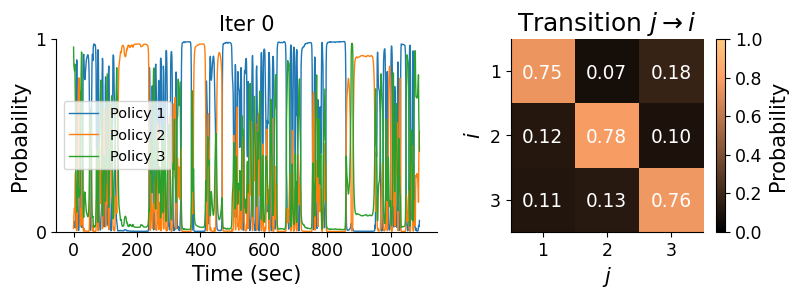

In [7]:
# block_idx = rng.choice(manager.num_blocks)
block_idx = 9
gammas = torch.stack(manager.gammas[block_idx])
As = torch.stack(manager.As).numpy()
N = num_policies

fig, axes = plt.subplots(1, 2, figsize=(9, 2.5), gridspec_kw={'width_ratios': [1.5, 1]})
ax = axes[0]
h_gammas = ax.plot(gammas[0], linewidth=1)
h_title = ax.set_title('', fontsize='medium')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.legend(h_gammas, [f'Policy {i+1}' for i in range(N)], loc='center left', fontsize='x-small')
ax = axes[1]
h_A = ax.imshow(As[0], vmin=0, vmax=1, extent=[0.5, N+0.5, N+0.5, 0.5], cmap='copper')
h_probs = np.empty((N, N), dtype=object)
for i in range(N):
    for j in range(N):
        h_probs[i, j] = ax.text(
            j+1, i+1, '{:.2f}'.format(As[0, i, j]), ha='center', va='center_baseline',
            color='white', fontsize=40/N,
        )
ax.set_xlim([0.5, N+0.5]), ax.set_ylim([N+0.5, 0.5])
ax.set_xticks(np.arange(N)+1), ax.set_yticks(np.arange(N)+1)
ax.set_title(r'Transition $j \rightarrow i$')
ax.set_xlabel('$j$'), ax.set_ylabel('$i$')
plt.colorbar(
    h_A, ax=ax, shrink=1, label='Probability',
)

def update(t):
    for i in range(num_policies):
        h_gammas[i].set_ydata(gammas[t, :, i])
    h_A.set_data(As[t])
    h_title.set_text(f'Iter {t}')
    for i in range(N):
        for j in range(N):
            h_probs[i, j].set_text('{:.2f}'.format(As[t, i, j]))
    return *h_gammas, h_A, h_title, *h_probs.flatten()

ani = FuncAnimation(
    fig, update, frames=range(len(gammas)), blit=False,
)

# HTML(ani.to_jshtml())
savename = 'EM.iteration_{}[block{:02d}]_[Np{}]_{}'.format(subject, block_idx, num_policies, key)
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')

## Visualizing occupancy

In [8]:
log_gammas, log_xis, log_Zs = e_step(hmp, knowns, beliefs, actions)

gammas = [torch.softmax(log_gammas[i], dim=1) for i in range(len(log_gammas))]
pi_labels = ['Policy '+chr(ord('A')+i)+' ({:.0%})'.format(torch.cat(gammas).mean(dim=0)[i]) for i in range(num_policies)]

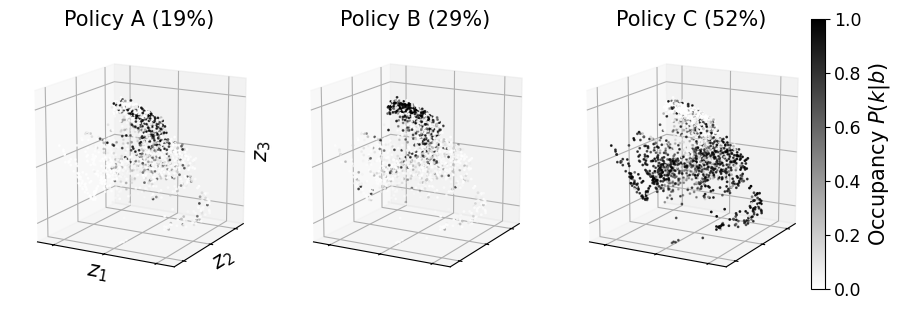

In [9]:
idxs = rng.choice(len(torch.cat(zs)), 2000, replace=False)
vals, colors = torch.cat(zs)[idxs], torch.cat(gammas)[idxs]
    
fig = plt.figure(figsize=(9, 3))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/3
axes, artists = [], []
labelpad = -12
for i in range(3):
    ax = fig.add_axes([0.2*margin+(width+gap)*i, 0.02, width, 0.9], projection='3d', elev=15)
    artists.append(ax.scatter(
        vals[:, 1], vals[:, 2], vals[:, 0], s=1,
        c=colors[:, i], cmap='gray_r', vmin=0, vmax=1,
    ))
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
    ax.zaxis.line.set_visible(False)
    for line in ax.zaxis.get_majorticklines():
        line.set_color('none')
    if i==0:
        ax.set_xlabel('$z_1$', labelpad=labelpad)
        ax.set_ylabel('$z_2$', labelpad=labelpad)
        ax.set_zlabel('$z_3$', labelpad=labelpad)
    ax.set_title(pi_labels[i], fontsize='medium')
    axes.append(ax)
cax = fig.add_axes([1-2*margin, margin, 0.3*margin, 1-2*margin])
cbar = plt.colorbar(artists[0], cax=cax, label='Occupancy $P(k|b)$')

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 360
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
savename = f'policy.occupancy.on.belief_{subject}_[kappa{kappa}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200, fps=24)
fig.savefig(FIG_DIR/f'{savename}.svg')

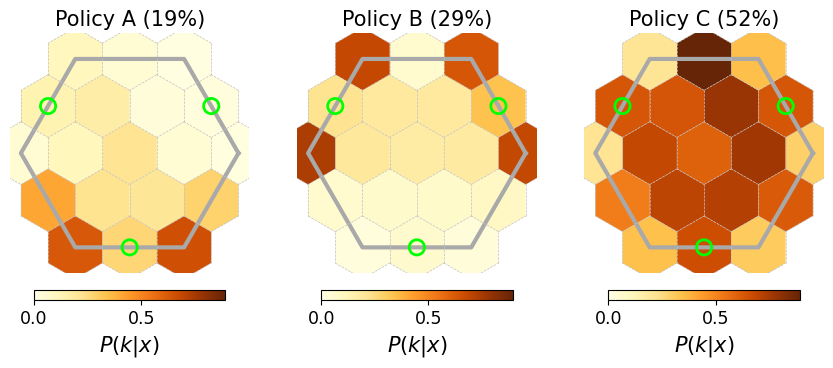

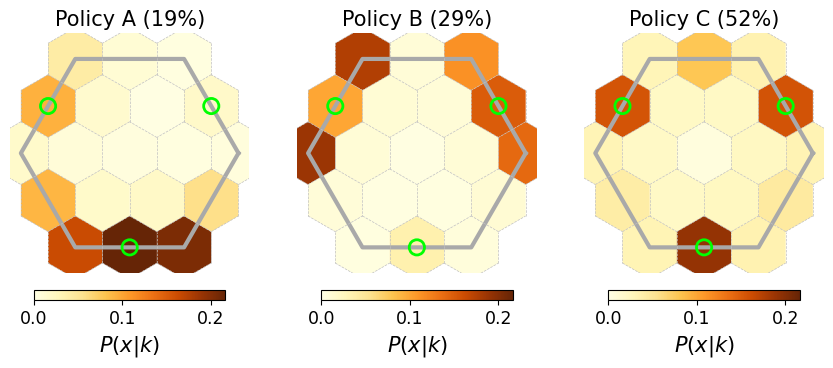

In [10]:
gammas_pos = []
for pos in range(env.arena.num_tiles):
    gammas_pos.append(torch.stack([gammas[i][(knowns[i][:, 0]==pos)].sum(dim=0) for i in range(len(gammas))]).sum(dim=0))
gammas_pos = torch.stack(gammas_pos)

vals = gammas_pos/gammas_pos.sum(dim=1, keepdims=True)
vmax = vals.max()
fig, axes = plt.subplots(1, num_policies, figsize=(3.5*num_policies, 4.5))
for i, ax in enumerate(axes):
    env.arena.plot_map(ax, vals[:, i], vmax=vmax, cbar_kw={'label': '$P(k|x)$', 'location': 'bottom'})
    ax.set_title(pi_labels[i], fontsize='medium')
fig.savefig(FIG_DIR/f'policy.occupancy.on.space_{subject}_[kappa{kappa}].svg')

vals = gammas_pos/gammas_pos.sum(dim=0, keepdims=True)
vmax = vals.max()
fig, axes = plt.subplots(1, num_policies, figsize=(3.5*num_policies, 4.5))
for i, ax in enumerate(axes):
    env.arena.plot_map(ax, vals[:, i], vmax=vmax, cbar_kw={'label': '$P(x|k)$', 'location': 'bottom'})
    ax.set_title(pi_labels[i], fontsize='medium')
fig.savefig(FIG_DIR/f'space.occupancy.of.policy_{subject}_[kappa{kappa}].svg')

## Visualizing policy

In [11]:
logps = [None]*manager.num_blocks
for i in range(manager.num_blocks):
    with torch.no_grad():
        inputs = hmp.policy_inputs(knowns[i].to(hmp.device), beliefs[i].to(hmp.device))
        _, logps[i] = hmp.action_probs(inputs)

push_only = True
if push_only:
    ps_action, idxs_action = torch.max(torch.cat(logps).exp()[..., :3], dim=2)
else:
    ps_action, idxs_action = torch.max(torch.cat(logps).exp(), dim=2)

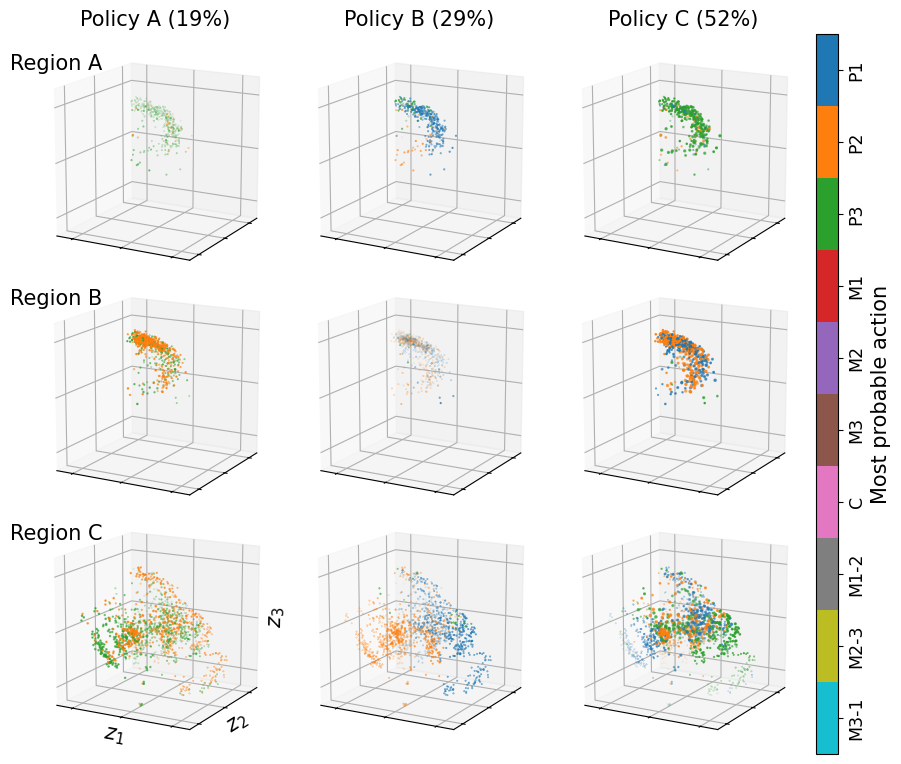

In [12]:
palette = plt.get_cmap('tab10').colors

fig = plt.figure(figsize=(9, 8))
h_margin, h_gap = 0.05, -0.02
width = (1-2*h_margin-2*h_gap)/3
v_margin, v_gap = 0.05, -0.02
height = (1-2*v_margin-2*v_gap)/3
labelpad = -12
axes, artists = [], []
for k in range(3):
    # idxs = torch.max(_gammas, dim=1)[1]==k
    mask = torch.cat(gammas)[:, k]>0.9
    mask = mask&(torch.rand(mask.shape)<0.1)
    vals = torch.cat(zs)[mask]
    fig.text(
        0.1*h_margin, 0.5*v_margin+(height+v_gap)*(3-k),
        'Region '+chr(ord('A')+k), transform=fig.transFigure,
    )
    
    for i in range(3):
        ax = fig.add_axes(
            [0.2*h_margin+(width+h_gap)*i, v_margin+(height+v_gap)*(2-k), width, height], projection='3d', elev=15,
        )
        if push_only:
            sizes = ps_action[mask][:, i]*4
        else:
            sizes = ps_action[mask][:, i]**3*2
        colors = np.stack([palette[_c] for _c in idxs_action[mask][:, i]])
        artists.append(ax.scatter(
            vals[:, 1], vals[:, 2], vals[:, 0], s=sizes, c=colors,
        ))
        ax_lim = [-4, 4]
        ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
        ax.set_aspect('equal')
        ax_ticks = [-3, 0, 3]
        ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
        ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
        ax.zaxis.line.set_visible(False)
        for line in ax.zaxis.get_majorticklines():
            line.set_color('none')
        if i==0 and k==2:
            ax.set_xlabel('$z_1$', labelpad=labelpad)
            ax.set_ylabel('$z_2$', labelpad=labelpad)
            ax.set_zlabel('$z_3$', labelpad=labelpad)
        if k==0:
            ax.set_title(pi_labels[i], fontsize='medium')
        axes.append(ax)
cax = fig.add_axes([1-2*h_margin, v_margin, 0.5*h_margin, 1-2*v_margin])
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), cax=cax,
    orientation='vertical', aspect=15*num_policies, pad=0.15,
    label='Most probable action',
)
cbar.ax.yaxis.set_inverted(True)
cbar.ax.set_yticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_yticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90, verticalalignment='center')

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 360
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
savename = f"policy.comparison_{subject}_[kappa{kappa}][{'P' if push_only else 'A'}]"
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200, fps=24)
fig.savefig(FIG_DIR/f'{savename}.svg')